# Week 5: LangGraph 인지 아키텍처 - 의도 분류 + 라우팅 시스템

## 과제 개요
- **주제**: 사용자 의도에 따라 다른 처리 경로로 분기하는 인지 아키텍처 설계
- **목표**: Router 노드로 의도 분류 → 조건부 엣지로 라우팅 → 의도별 처리 노드 실행
- **핵심**: LangGraph의 `add_conditional_edges`로 그래프 내에서 분기

## 구현 구조
```
사용자 질문
    ↓
[Router] 의도 분류 (DOC_QA / SUMMARY / SMALL_TALK)
    ↓
┌─────────┬──────────┬─────────────┐
│ DOC_QA  │ SUMMARY  │ SMALL_TALK  │
│ (RAG)   │ (요약)    │ (잡담)       │
└────┬────┴─────┬────┴──────┬──────┘
     ↓          ↓           ↓
   RAG 답변   요약 답변   일반 답변
```

## 마일스톤
1. State 설계 + 문서 로드
2. Router 노드 (의도 분류)
3. 의도별 처리 노드 (DOC_QA, SUMMARY, SMALL_TALK)
4. 조건부 분기 그래프 구성
5. 3개 시나리오 테스트

In [1]:
print("="*80)
print("Cell 2: 라이브러리 Import")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 기본 라이브러리
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# LangChain Core
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_experimental.text_splitter import SemanticChunker
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# LangGraph (핵심!)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated, Literal
from langgraph.graph.message import add_messages

print("✅ 라이브러리 Import 완료")

Cell 2: 라이브러리 Import


USER_AGENT environment variable not set, consider setting it to identify your requests.


✅ 라이브러리 Import 완료


In [2]:
print("\n" + "="*80)
print("Cell 3: API 키 로드 및 전역 설정")
print("="*80)

# API 키 로드
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file")

print("✅ OpenAI API 키 로드 완료")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 전역 설정
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# LLM
LLM_MODEL = "gpt-4o-mini"
LLM_TEMPERATURE = 0.2

llm = ChatOpenAI(
    model=LLM_MODEL,
    temperature=LLM_TEMPERATURE,
    api_key=openai_api_key
)

# Embeddings
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=openai_api_key
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Text Splitter: Semantic Chunking
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size=1000,
#     chunk_overlap=200
# )

text_splitter = SemanticChunker(
    embeddings=embeddings,
    breakpoint_threshold_type="percentile",  # "percentile", "standard_deviation", "interquartile"
    breakpoint_threshold_amount=95  # 상위 5% 유사도 차이에서 분할
)

print(f"✅ LLM: {LLM_MODEL}")
print(f"✅ Embeddings: text-embedding-3-small")
print(f"✅ Text Splitter: SemanticChunker")
print(f"   - Breakpoint type: percentile")
print(f"   - Threshold: 95 (상위 5% 의미 변화 지점에서 분할)")

'''
[Semantic Chunking 특징]
- 의미 기반 분할: 문장 간 유사도로 자동 분할
- 가변 청크 크기: 의미 단위에 따라 크기 조정
- 장점: 맥락 보존, 의미 단위 유지
- 단점: 처리 시간 증가 (임베딩 계산)

[Breakpoint 유형]
- percentile: 상위 X% 유사도 차이에서 분할
- standard_deviation: 표준편차 기준 분할
- interquartile: 사분위수 기준 분할
'''


Cell 3: API 키 로드 및 전역 설정
✅ OpenAI API 키 로드 완료
✅ LLM: gpt-4o-mini
✅ Embeddings: text-embedding-3-small
✅ Text Splitter: SemanticChunker
   - Breakpoint type: percentile
   - Threshold: 95 (상위 5% 의미 변화 지점에서 분할)


'\n[Semantic Chunking 특징]\n- 의미 기반 분할: 문장 간 유사도로 자동 분할\n- 가변 청크 크기: 의미 단위에 따라 크기 조정\n- 장점: 맥락 보존, 의미 단위 유지\n- 단점: 처리 시간 증가 (임베딩 계산)\n\n[Breakpoint 유형]\n- percentile: 상위 X% 유사도 차이에서 분할\n- standard_deviation: 표준편차 기준 분할\n- interquartile: 사분위수 기준 분할\n'

In [3]:
print("\n" + "="*80)
print("Cell 4: 문서 URL 정의 (검증된 링크)")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 문서 구성 전략:
# - API Reference: 함수 설명 (DOC_QA)
# - Conceptual Docs: 개념 설명 (DOC_QA + SUMMARY)
# - Tutorials: 구현 가이드 (SUMMARY)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

document_urls = {
    # ────────────────────────────────────────────────────────────
    # LangChain RAG Tutorials - 4개
    # ────────────────────────────────────────────────────────────
    "rag_agent": "https://docs.langchain.com/oss/python/langchain/rag",
    # ✅ 검증: RAG agent 구현 (Lilian Weng 블로그)
    
    "semantic_search": "https://docs.langchain.com/oss/python/langchain/knowledge-base",
    # ✅ 검증: 시맨틱 검색 튜토리얼
    
    "sql_agent": "https://docs.langchain.com/oss/python/langchain/sql-agent",
    # ✅ SQL Agent 구현
    
    "agents_tutorial": "https://docs.langchain.com/oss/python/langchain/agents",
    # ✅ Agent 개념 및 구현
    
    # ────────────────────────────────────────────────────────────
    # LangChain Concepts - 4개
    # ────────────────────────────────────────────────────────────
    "component_architecture": "https://docs.langchain.com/oss/python/langchain/component-architecture",
    # ✅ 컴포넌트 아키텍처
    
    "memory_concepts": "https://docs.langchain.com/oss/python/concepts/memory",
    # ✅ Memory 개념
    
    "context_concepts": "https://docs.langchain.com/oss/python/concepts/context",
    # ✅ Context 관리
    
    "retrieval_concepts": "https://docs.langchain.com/oss/python/langchain/retrieval",
    # ✅ Retrieval 개념
    
    # ────────────────────────────────────────────────────────────
    # LangGraph Tutorials - 3개
    # ────────────────────────────────────────────────────────────
    "langgraph_overview": "https://docs.langchain.com/oss/python/langgraph/overview",
    # ✅ LangGraph 개요
    
    "langgraph_graph_api": "https://docs.langchain.com/oss/python/langgraph/graph-api",
    # ✅ Graph API
    
    "langgraph_agentic_rag": "https://docs.langchain.com/oss/python/langgraph/agentic-rag",
    # ✅ Agentic RAG (라우팅 예제!)
    
    # ────────────────────────────────────────────────────────────
    # LangChain How-to - 2개
    # ────────────────────────────────────────────────────────────
    "streaming": "https://docs.langchain.com/oss/python/langchain/streaming",
    # ✅ Streaming 구현
    
    "structured_output": "https://docs.langchain.com/oss/python/langchain/structured-output",
    # ✅ Structured Output
}

all_urls = list(document_urls.values())

print(f"총 {len(all_urls)}개 문서 URL 정의 완료\n")

print("문서 카테고리:")
print(f"  ✅ LangChain RAG Tutorials: 4개")
print(f"  ✅ LangChain Concepts: 4개")
print(f"  ✅ LangGraph Tutorials: 3개")
print(f"  ✅ LangChain How-to: 2개")
print(f"  ─────────────────────────────────")
print(f"  총 13개 (모두 docs.langchain.com 통일)")

print("\n사용 시나리오:")
print("  - DOC_QA (기술 Q&A): 개념 + 구현 방법")
print("  - SUMMARY (요약): 튜토리얼 + 개념 문서")
print("  - SMALL_TALK (잡담): 문서 불필요")

print("\n주요 링크 검증:")
for name, url in list(document_urls.items())[:3]:
    print(f"  ✓ {name}: {url}")
print("  ...")


Cell 4: 문서 URL 정의 (검증된 링크)
총 13개 문서 URL 정의 완료

문서 카테고리:
  ✅ LangChain RAG Tutorials: 4개
  ✅ LangChain Concepts: 4개
  ✅ LangGraph Tutorials: 3개
  ✅ LangChain How-to: 2개
  ─────────────────────────────────
  총 13개 (모두 docs.langchain.com 통일)

사용 시나리오:
  - DOC_QA (기술 Q&A): 개념 + 구현 방법
  - SUMMARY (요약): 튜토리얼 + 개념 문서
  - SMALL_TALK (잡담): 문서 불필요

주요 링크 검증:
  ✓ rag_agent: https://docs.langchain.com/oss/python/langchain/rag
  ✓ semantic_search: https://docs.langchain.com/oss/python/langchain/knowledge-base
  ✓ sql_agent: https://docs.langchain.com/oss/python/langchain/sql-agent
  ...


In [4]:
print("\n" + "="*80)
print("Cell 5: 문서 로드")
print("="*80)

print(f"\n{len(all_urls)}개 URL에서 문서 로드 중...")
print("(WebBaseLoader 사용, 시간이 다소 걸릴 수 있습니다)\n")

# WebBaseLoader로 문서 로드
import bs4
loader = WebBaseLoader(
    web_paths=all_urls,
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(id="content-area")
    )
)
# loader = WebBaseLoader(all_urls)
docs = loader.load()

print(f"✅ 총 {len(docs)}개 문서 로드 완료")

# 문서별 정보 출력 (샘플)
print("\n[샘플] 처음 3개 문서:")
for i, doc in enumerate(docs[:3], 1):
    print(f"\n문서 {i}:")
    print(f"  - Source: {doc.metadata.get('source', 'N/A')}")
    print(f"  - Length: {len(doc.page_content)} characters")
    print(f"  - Preview: {doc.page_content[:100]}...")


Cell 5: 문서 로드

13개 URL에서 문서 로드 중...
(WebBaseLoader 사용, 시간이 다소 걸릴 수 있습니다)

✅ 총 13개 문서 로드 완료

[샘플] 처음 3개 문서:

문서 1:
  - Source: https://docs.langchain.com/oss/python/langchain/rag
  - Length: 30612 characters
  - Preview: TutorialsLangChainBuild a RAG agent with LangChainCopy pageCopy page‚ÄãOverview
One of the most powe...

문서 2:
  - Source: https://docs.langchain.com/oss/python/langchain/knowledge-base
  - Length: 26461 characters
  - Preview: TutorialsLangChainBuild a semantic search engine with LangChainCopy pageCopy page​Overview
This tuto...

문서 3:
  - Source: https://docs.langchain.com/oss/python/langchain/sql-agent
  - Length: 19320 characters
  - Preview: TutorialsLangChainBuild a SQL agentCopy pageCopy page‚ÄãOverview
In this tutorial, you will learn ho...


In [5]:
print("\n" + "="*80)
print("Cell 6: 문서 청킹 (SemanticChunker)")
print("="*80)

print("의미 기반 청킹 진행 중...")
print("(임베딩 계산으로 인해 시간이 다소 걸릴 수 있습니다)\n")

# 문서 청킹
chunks = text_splitter.split_documents(docs)

print(f"✅ 총 {len(chunks)}개 청크 생성 완료")

# 청킹 통계
chunk_sizes = [len(chunk.page_content) for chunk in chunks]
total_chars = sum(chunk_sizes)
avg_chunk_size = total_chars / len(chunks)
min_chunk_size = min(chunk_sizes)
max_chunk_size = max(chunk_sizes)

print(f"\n청킹 통계:")
print(f"  - 총 문서 수: {len(docs)}개")
print(f"  - 총 청크 수: {len(chunks)}개")
print(f"  - 평균 청크 크기: {avg_chunk_size:.0f} characters")
print(f"  - 최소 청크 크기: {min_chunk_size} characters")
print(f"  - 최대 청크 크기: {max_chunk_size} characters")
print(f"  - 청킹 방식: Semantic (의미 기반)")

# 청크 크기 분포 (간단한 히스토그램)
print("\n청크 크기 분포:")
ranges = [
    (0, 500, "0-500"),
    (500, 1000, "500-1000"),
    (1000, 1500, "1000-1500"),
    (1500, 2000, "1500-2000"),
    (2000, float('inf'), "2000+")
]

for min_size, max_size, label in ranges:
    count = sum(1 for size in chunk_sizes if min_size <= size < max_size)
    bar = "█" * (count // 5 if count > 0 else 0)
    print(f"  {label:12s}: {count:3d}개 {bar}")

# 샘플 청크
print(f"\n[샘플] 첫 번째 청크:")
print(f"  - Source: {chunks[0].metadata.get('source', 'N/A')}")
print(f"  - Size: {len(chunks[0].page_content)} characters")
print(f"  - Content: {chunks[0].page_content[:300]}...")

if len(chunks) > 1:
    print(f"\n[샘플] 두 번째 청크:")
    print(f"  - Source: {chunks[1].metadata.get('source', 'N/A')}")
    print(f"  - Size: {len(chunks[1].page_content)} characters")
    print(f"  - Content: {chunks[1].page_content[:300]}...")


Cell 6: 문서 청킹 (SemanticChunker)
의미 기반 청킹 진행 중...
(임베딩 계산으로 인해 시간이 다소 걸릴 수 있습니다)

✅ 총 66개 청크 생성 완료

청킹 통계:
  - 총 문서 수: 13개
  - 총 청크 수: 66개
  - 평균 청크 크기: 3439 characters
  - 최소 청크 크기: 11 characters
  - 최대 청크 크기: 18894 characters
  - 청킹 방식: Semantic (의미 기반)

청크 크기 분포:
  0-500       :  12개 ██
  500-1000    :   5개 █
  1000-1500   :   8개 █
  1500-2000   :   8개 █
  2000+       :  33개 ██████

[샘플] 첫 번째 청크:
  - Source: https://docs.langchain.com/oss/python/langchain/rag
  - Size: 269 characters
  - Content: TutorialsLangChainBuild a RAG agent with LangChainCopy pageCopy page‚ÄãOverview
One of the most powerful applications enabled by LLMs is sophisticated question-answering (Q&A) chatbots. These are applications that can answer questions about specific source information....

[샘플] 두 번째 청크:
  - Source: https://docs.langchain.com/oss/python/langchain/rag
  - Size: 4571 characters
  - Content: These applications use a technique known as Retrieval Augmented Generation, or RAG. This tutorial will s

In [6]:
# 샘플 청크
sidx = 24
print(f"\n[샘플] {sidx} 번째 청크:")
print(f"  - Source: {chunks[sidx].metadata.get('source', 'N/A')}")
print(f"  - Size: {len(chunks[sidx].page_content)} characters")
print(f"  - Content: {chunks[sidx].page_content[:300]}...")


[샘플] 24 번째 청크:
  - Source: https://docs.langchain.com/oss/python/langchain/agents
  - Size: 1760 characters
  - Content: For information on implementing long-term memory that persists across sessions, see Long-term memory. ​Streaming
We’ve seen how the agent can be called with invoke to get a final response. If the agent executes multiple steps, this may take a while. To show intermediate progress, we can stream back ...


In [7]:
print("\n" + "="*80)
print("Cell 7: 벡터스토어 생성 (Chroma)")
print("="*80)

# Chroma 벡터스토어 생성
vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
    collection_name="week5_langgraph_docs"
)

print(f"✅ Chroma 벡터스토어 생성 완료")
print(f"  - Collection: week5_langgraph_docs")
print(f"  - 총 벡터 수: {len(chunks)}개")
print(f"  - Embedding 모델: text-embedding-3-small")


Cell 7: 벡터스토어 생성 (Chroma)
✅ Chroma 벡터스토어 생성 완료
  - Collection: week5_langgraph_docs
  - 총 벡터 수: 66개
  - Embedding 모델: text-embedding-3-small


In [8]:
print("\n" + "="*80)
print("Cell 8: Retriever 생성")
print("="*80)

# Retriever 생성
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
)

print("✅ Retriever 생성 완료")
print("  - Search type: similarity")
print("  - k: 4 (상위 4개 문서 검색)")

# 테스트 검색
test_query = "What is RAG?"
test_results = retriever.invoke(test_query)

print(f"\n[테스트 검색] Query: '{test_query}'")
print(f"검색 결과: {len(test_results)}개 문서")
for i, doc in enumerate(test_results, 1):
    print(f"\n  Doc {i}:")
    print(f"    Source: {doc.metadata.get('source', 'N/A')[:60]}...")
    print(f"    Content: {doc.page_content[:100]}...")


Cell 8: Retriever 생성
✅ Retriever 생성 완료
  - Search type: similarity
  - k: 4 (상위 4개 문서 검색)

[테스트 검색] Query: 'What is RAG?'
검색 결과: 4개 문서

  Doc 1:
    Source: https://docs.langchain.com/oss/python/langchain/retrieval...
    Content: Advanced usageRetrievalCopy pageCopy pageLarge Language Models (LLMs) are powerful, but they have tw...

  Doc 2:
    Source: https://docs.langchain.com/oss/python/langchain/retrieval...
    Content: These systems offer more flexibility than fixed pipelines while maintaining some control over execut...

  Doc 3:
    Source: https://docs.langchain.com/oss/python/langchain/rag...
    Content: Interface: API reference for the base interface. This completes the Indexing portion of the pipeline...

  Doc 4:
    Source: https://docs.langchain.com/oss/python/langchain/rag...
    Content: These applications use a technique known as Retrieval Augmented Generation, or RAG. This tutorial wi...


In [9]:
print("\n" + "="*80)
print(f"현재 상태:")
print(f"  - 문서 수: {len(docs)}개")
print(f"  - 청크 수: {len(chunks)}개")
print(f"  - Retriever: Ready ✅")
print("="*80)


현재 상태:
  - 문서 수: 13개
  - 청크 수: 66개
  - Retriever: Ready ✅


# Section 1: State 설계 및 Router 노드 (Milestone 2)
---

## 목표
- ChatState 정의 (messages, query, intent, context)
- Router 노드 구현 (LLM 기반 의도 분류)
- 3가지 의도 분류: DOC_QA, SUMMARY, SMALL_TALK

## 의도(Intent) 정의
1. **DOC_QA**: 기술 문서 질문 → RAG 처리
   - 예: "RAG란 무엇인가요?", "Retriever 종류는?"
   
2. **SUMMARY**: 요약 요청 → 요약 노드
   - 예: "이 문서 요약해줘", "핵심만 3개 뽑아줘"
   
3. **SMALL_TALK**: 일반 대화 → RAG 없이 LLM만
   - 예: "안녕", "고마워", "너 뭐야?"

## Router 동작 원리사용자 질문
↓
[Router] LLM으로 의도 분류
↓
state["intent"] = "DOC_QA" | "SUMMARY" | "SMALL_TALK"
↓
조건부 엣지로 분기

In [10]:
print("="*80)
print("Cell 11: 1.1 ChatState 정의")
print("="*80)

from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# ChatState 정의
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

class ChatState(TypedDict):
    """LangGraph 인지 아키텍처 State
    
    Attributes:
        messages: 대화 메시지 리스트 (자동 누적)
        query: 현재 사용자 질문
        intent: 분류된 의도 (DOC_QA | SUMMARY | SMALL_TALK)
        context: RAG 검색 결과 (문서 내용)
    """
    messages: Annotated[list[BaseMessage], add_messages]
    query: str
    intent: str  # "DOC_QA" | "SUMMARY" | "SMALL_TALK"
    context: str

print("✅ ChatState 정의 완료")

print("""
State 필드 설명:
  - messages: LangGraph의 add_messages로 자동 누적
  - query: 사용자의 현재 질문 (Router가 분석)
  - intent: Router가 분류한 의도 (3가지 중 하나)
  - context: DOC_QA/SUMMARY 노드에서 검색한 문서 내용
  
의도(Intent) 3가지:
  1. DOC_QA: 기술 질문 → RAG 검색 + 답변
  2. SUMMARY: 요약 요청 → 검색 + 요약
  3. SMALL_TALK: 잡담 → LLM만 사용
""")

Cell 11: 1.1 ChatState 정의
✅ ChatState 정의 완료

State 필드 설명:
  - messages: LangGraph의 add_messages로 자동 누적
  - query: 사용자의 현재 질문 (Router가 분석)
  - intent: Router가 분류한 의도 (3가지 중 하나)
  - context: DOC_QA/SUMMARY 노드에서 검색한 문서 내용

의도(Intent) 3가지:
  1. DOC_QA: 기술 질문 → RAG 검색 + 답변
  2. SUMMARY: 요약 요청 → 검색 + 요약
  3. SMALL_TALK: 잡담 → LLM만 사용



In [14]:
print("\n" + "="*80)
print("Cell 12: 1.2 의도 분류 프롬프트 설계")
print("="*80)

from langchain_core.prompts import PromptTemplate

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Router용 의도 분류 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

intent_classification_template = """당신은 사용자 질문의 의도를 분류하는 전문가입니다.

사용자 질문을 분석하여 다음 3가지 의도 중 하나로 분류하세요:

1. **DOC_QA**: 기술 문서에 대한 구체적인 질문
   - 예시: "RAG란 무엇인가요?", "Retriever 종류는?", "LangGraph에서 State란?"
   - 키워드: what, how, explain, 무엇, 어떻게, 설명

2. **SUMMARY**: 문서 요약 또는 정리 요청
   - 예시: "이 문서 요약해줘", "핵심만 3개 뽑아줘", "간단히 정리해줘"
   - 키워드: 요약, 정리, summarize, 핵심, 간단히, 포인트

3. **SMALL_TALK**: 일반 대화, 인사, 감사 표현
   - 예시: "안녕", "고마워", "너 뭐야?", "잘 지내?"
   - 키워드: 안녕, 감사, hello, thanks, hi

중요: 반드시 "DOC_QA", "SUMMARY", "SMALL_TALK" 중 정확히 하나만 출력하세요.
다른 말은 일체 하지 마세요.

사용자 질문: {query}

의도:"""

intent_prompt = PromptTemplate(
    template=intent_classification_template,
    input_variables=["query"]
)

print("✅ 의도 분류 프롬프트 생성 완료")

# 프롬프트 테스트
print("\n[프롬프트 미리보기]")
test_query = "RAG란 무엇인가요?"
print(intent_prompt.format(query=test_query)[:500] + "...")


Cell 12: 1.2 의도 분류 프롬프트 설계
✅ 의도 분류 프롬프트 생성 완료

[프롬프트 미리보기]
당신은 사용자 질문의 의도를 분류하는 전문가입니다.

사용자 질문을 분석하여 다음 3가지 의도 중 하나로 분류하세요:

1. **DOC_QA**: 기술 문서에 대한 구체적인 질문
   - 예시: "RAG란 무엇인가요?", "Retriever 종류는?", "LangGraph에서 State란?"
   - 키워드: what, how, explain, 무엇, 어떻게, 설명

2. **SUMMARY**: 문서 요약 또는 정리 요청
   - 예시: "이 문서 요약해줘", "핵심만 3개 뽑아줘", "간단히 정리해줘"
   - 키워드: 요약, 정리, summarize, 핵심, 간단히, 포인트

3. **SMALL_TALK**: 일반 대화, 인사, 감사 표현
   - 예시: "안녕", "고마워", "너 뭐야?", "잘 지내?"
   - 키워드: 안녕, 감사, hello, thanks, hi

중요: 반드시 "DOC_QA", "SUMMARY", "SMALL_TALK" 중 정확히 하나만 출력하세요.
다...


In [15]:
print("\n" + "="*80)
print("Cell 13: 1.3 Router 노드 구현 (LLM 기반)")
print("="*80)

from langchain_core.output_parsers import StrOutputParser

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 의도 분류 체인 생성
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

intent_chain = intent_prompt | llm | StrOutputParser()

print("✅ 의도 분류 체인 생성 완료")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Router 노드 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def router_node(state: ChatState) -> ChatState:
    """의도 분류 노드
    
    사용자 질문(query)을 분석하여 의도를 분류합니다.
    
    Args:
        state: 현재 그래프 상태
        
    Returns:
        업데이트된 상태 (intent 필드 추가)
    """
    query = state["query"]
    
    print(f"\n[Router] 질문 분석 중: '{query}'")
    
    # LLM으로 의도 분류
    raw_intent = intent_chain.invoke({"query": query})
    
    # 의도 정제 (공백 제거, 대문자 변환)
    intent = raw_intent.strip().upper()
    
    # 유효성 검사
    valid_intents = ["DOC_QA", "SUMMARY", "SMALL_TALK"]
    if intent not in valid_intents:
        # LLM이 잘못된 출력을 했을 경우 기본값 설정
        print(f"  ⚠️ 유효하지 않은 의도: '{intent}' → 기본값 'DOC_QA' 사용")
        intent = "DOC_QA"
    
    print(f"  ✅ 분류된 의도: {intent}")
    
    return {"intent": intent}

print("✅ Router 노드 함수 정의 완료")


Cell 13: 1.3 Router 노드 구현 (LLM 기반)
✅ 의도 분류 체인 생성 완료
✅ Router 노드 함수 정의 완료


In [16]:
print("\n" + "="*80)
print("Cell 14: 1.4 Router 노드 테스트")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 테스트 질문들
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

test_questions = [
    # DOC_QA 예상
    "RAG란 무엇인가요?",
    "LangGraph에서 State는 어떻게 사용하나요?",
    "Retriever의 종류를 알려주세요",
    
    # SUMMARY 예상
    "이 문서를 요약해줘",
    "핵심 포인트 3개만 뽑아줘",
    "간단히 정리해주세요",
    
    # SMALL_TALK 예상
    "안녕하세요",
    "고마워요",
    "당신은 누구인가요?"
]

print(f"총 {len(test_questions)}개 질문으로 Router 테스트\n")

# 각 질문에 대해 의도 분류 테스트
results = []

for i, question in enumerate(test_questions, 1):
    # State 구성
    test_state = {
        "messages": [],
        "query": question,
        "intent": "",
        "context": ""
    }
    
    # Router 실행
    result = router_node(test_state)
    intent = result["intent"]
    
    results.append({
        "question": question,
        "intent": intent
    })
    
    print()  # 줄바꿈

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 결과 요약
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("Router 테스트 결과 요약")
print("="*80)

# 의도별 카운트
from collections import Counter
intent_counts = Counter(r["intent"] for r in results)

print("\n의도별 분류 결과:")
for intent, count in intent_counts.items():
    print(f"  - {intent}: {count}개")

# 상세 결과 표
print("\n상세 결과:")
print("-" * 80)
print(f"{'질문':<40} | {'의도':<15}")
print("-" * 80)
for r in results:
    print(f"{r['question']:<40} | {r['intent']:<15}")
print("-" * 80)


Cell 14: 1.4 Router 노드 테스트
총 9개 질문으로 Router 테스트


[Router] 질문 분석 중: 'RAG란 무엇인가요?'
  ✅ 분류된 의도: DOC_QA


[Router] 질문 분석 중: 'LangGraph에서 State는 어떻게 사용하나요?'
  ✅ 분류된 의도: DOC_QA


[Router] 질문 분석 중: 'Retriever의 종류를 알려주세요'
  ✅ 분류된 의도: DOC_QA


[Router] 질문 분석 중: '이 문서를 요약해줘'
  ✅ 분류된 의도: SUMMARY


[Router] 질문 분석 중: '핵심 포인트 3개만 뽑아줘'
  ✅ 분류된 의도: SUMMARY


[Router] 질문 분석 중: '간단히 정리해주세요'
  ✅ 분류된 의도: SUMMARY


[Router] 질문 분석 중: '안녕하세요'
  ✅ 분류된 의도: SMALL_TALK


[Router] 질문 분석 중: '고마워요'
  ✅ 분류된 의도: SMALL_TALK


[Router] 질문 분석 중: '당신은 누구인가요?'
  ✅ 분류된 의도: SMALL_TALK


Router 테스트 결과 요약

의도별 분류 결과:
  - DOC_QA: 3개
  - SUMMARY: 3개
  - SMALL_TALK: 3개

상세 결과:
--------------------------------------------------------------------------------
질문                                       | 의도             
--------------------------------------------------------------------------------
RAG란 무엇인가요?                              | DOC_QA         
LangGraph에서 State는 어떻게 사용하나요?            | DOC_QA         
Retriever의 종류를 알려

# Section 2: 의도별 처리 노드 (Milestone 3)
---

## 목표
- 3가지 의도별 처리 노드 구현
- 각 노드는 ChatState를 받아서 답변 생성

## 노드 구조
```
1. DOC_QA 노드
   - Retriever로 문서 검색
   - 검색 결과 + 질문 → LLM
   - 기술 문서 기반 답변

2. SUMMARY 노드
   - Retriever로 문서 검색
   - 검색 결과를 요약
   - 핵심 내용 추출

3. SMALL_TALK 노드
   - Retriever 사용 안 함
   - LLM만으로 답변
   - 일반 대화 처리
```

## 노드 출력
- 모든 노드는 messages에 AIMessage 추가
- DOC_QA/SUMMARY는 context도 업데이트

In [17]:
print("="*80)
print("Cell 17: 2.1 DOC_QA 노드 구현")
print("="*80)

from langchain_core.messages import HumanMessage, AIMessage

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# DOC_QA용 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

doc_qa_template = """당신은 LangChain/LangGraph 기술 문서 전문가입니다.

제공된 문서를 기반으로 사용자 질문에 정확하게 답변하세요.

규칙:
- 문서에 있는 내용만 사용
- 문서에 없으면 "제공된 문서에 해당 정보가 없습니다"
- 간결하고 명확하게 답변
- 필요시 예제 코드 포함

검색된 문서:
{context}

질문: {question}

답변:"""

doc_qa_prompt = PromptTemplate(
    template=doc_qa_template,
    input_variables=["context", "question"]
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# DOC_QA 노드 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def doc_qa_node(state: ChatState) -> ChatState:
    """DOC_QA 노드: 기술 문서 Q&A
    
    Retriever로 문서를 검색하고 LLM으로 답변 생성
    
    Args:
        state: 현재 그래프 상태
        
    Returns:
        업데이트된 상태 (messages, context)
    """
    query = state["query"]
    
    print(f"\n[DOC_QA] 질문: '{query}'")
    
    # 1. 문서 검색
    print(f"  [1/3] Retriever로 문서 검색 중...")
    docs = retriever.invoke(query)
    
    # 검색된 문서 내용 합치기
    context = "\n\n".join([
        f"[문서 {i+1}]\n{doc.page_content}" 
        for i, doc in enumerate(docs)
    ])
    
    print(f"  ✅ {len(docs)}개 문서 검색 완료")
    
    # 2. LLM으로 답변 생성
    print(f"  [2/3] LLM으로 답변 생성 중...")
    
    answer = (doc_qa_prompt | llm | StrOutputParser()).invoke({
        "context": context,
        "question": query
    })
    
    print(f"  ✅ 답변 생성 완료 ({len(answer)} characters)")
    
    # 3. State 업데이트
    print(f"  [3/3] State 업데이트 중...")
    
    # messages에 AI 답변 추가
    ai_message = AIMessage(content=answer)
    
    print(f"  ✅ DOC_QA 노드 완료")
    
    return {
        "messages": [ai_message],
        "context": context
    }

print("✅ DOC_QA 노드 구현 완료")

Cell 17: 2.1 DOC_QA 노드 구현
✅ DOC_QA 노드 구현 완료


In [18]:
print("\n" + "="*80)
print("Cell 18: 2.2 SUMMARY 노드 구현")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# SUMMARY용 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

summary_template = """당신은 기술 문서 요약 전문가입니다.

제공된 문서를 분석하여 사용자가 요청한 방식으로 요약하세요.

요약 규칙:
- 핵심 내용만 간결하게
- 사용자 요청 형식 준수 (예: "3가지", "간단히")
- 불렛 포인트 또는 번호 사용
- 기술 용어는 정확하게 유지

검색된 문서:
{context}

사용자 요청: {question}

요약:"""

summary_prompt = PromptTemplate(
    template=summary_template,
    input_variables=["context", "question"]
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# SUMMARY 노드 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def summary_node(state: ChatState) -> ChatState:
    """SUMMARY 노드: 문서 요약
    
    Retriever로 문서를 검색하고 LLM으로 요약 생성
    
    Args:
        state: 현재 그래프 상태
        
    Returns:
        업데이트된 상태 (messages, context)
    """
    query = state["query"]
    
    print(f"\n[SUMMARY] 요청: '{query}'")
    
    # 1. 문서 검색
    print(f"  [1/3] Retriever로 문서 검색 중...")
    docs = retriever.invoke(query)
    
    # 검색된 문서 내용 합치기
    context = "\n\n".join([
        f"[문서 {i+1}]\n{doc.page_content}" 
        for i, doc in enumerate(docs)
    ])
    
    print(f"  ✅ {len(docs)}개 문서 검색 완료")
    
    # 2. LLM으로 요약 생성
    print(f"  [2/3] LLM으로 요약 생성 중...")
    
    summary = (summary_prompt | llm | StrOutputParser()).invoke({
        "context": context,
        "question": query
    })
    
    print(f"  ✅ 요약 생성 완료 ({len(summary)} characters)")
    
    # 3. State 업데이트
    print(f"  [3/3] State 업데이트 중...")
    
    # messages에 AI 답변 추가
    ai_message = AIMessage(content=summary)
    
    print(f"  ✅ SUMMARY 노드 완료")
    
    return {
        "messages": [ai_message],
        "context": context
    }

print("✅ SUMMARY 노드 구현 완료")


Cell 18: 2.2 SUMMARY 노드 구현
✅ SUMMARY 노드 구현 완료


In [19]:
print("\n" + "="*80)
print("Cell 19: 2.3 SMALL_TALK 노드 구현")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# SMALL_TALK용 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

small_talk_template = """당신은 친근한 AI 어시스턴트입니다.

사용자와 자연스럽게 대화하세요.

대화 규칙:
- 친절하고 자연스럽게
- 간결하게 답변
- 필요시 LangChain/LangGraph 관련 도움 제안

사용자: {question}

답변:"""

small_talk_prompt = PromptTemplate(
    template=small_talk_template,
    input_variables=["question"]
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# SMALL_TALK 노드 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def small_talk_node(state: ChatState) -> ChatState:
    """SMALL_TALK 노드: 일반 대화
    
    RAG 없이 LLM만으로 답변 생성
    
    Args:
        state: 현재 그래프 상태
        
    Returns:
        업데이트된 상태 (messages만)
    """
    query = state["query"]
    
    print(f"\n[SMALL_TALK] 대화: '{query}'")
    
    # 1. LLM으로 답변 생성 (RAG 없음)
    print(f"  [1/2] LLM으로 답변 생성 중...")
    
    answer = (small_talk_prompt | llm | StrOutputParser()).invoke({
        "question": query
    })
    
    print(f"  ✅ 답변 생성 완료 ({len(answer)} characters)")
    
    # 2. State 업데이트
    print(f"  [2/2] State 업데이트 중...")
    
    # messages에 AI 답변 추가
    ai_message = AIMessage(content=answer)
    
    print(f"  ✅ SMALL_TALK 노드 완료")
    
    return {
        "messages": [ai_message]
    }

print("✅ SMALL_TALK 노드 구현 완료")


Cell 19: 2.3 SMALL_TALK 노드 구현
✅ SMALL_TALK 노드 구현 완료


In [20]:
print("\n" + "="*80)
print("Cell 20: 2.4 처리 노드 테스트")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 각 노드별 테스트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

test_cases = [
    {
        "intent": "DOC_QA",
        "query": "RAG란 무엇인가요?",
        "node": doc_qa_node
    },
    {
        "intent": "SUMMARY",
        "query": "RAG 개념을 3가지로 요약해줘",
        "node": summary_node
    },
    {
        "intent": "SMALL_TALK",
        "query": "안녕하세요!",
        "node": small_talk_node
    }
]

print(f"총 {len(test_cases)}개 노드 테스트\n")

for i, test_case in enumerate(test_cases, 1):
    print("="*80)
    print(f"테스트 {i}/{len(test_cases)}: {test_case['intent']}")
    print("="*80)
    
    # State 구성
    test_state = {
        "messages": [],
        "query": test_case["query"],
        "intent": test_case["intent"],
        "context": ""
    }
    
    # 노드 실행
    result = test_case["node"](test_state)
    
    # 결과 출력
    print(f"\n[결과]")
    print(f"  - 답변 메시지: {len(result.get('messages', []))}개")
    if result.get("messages"):
        answer = result["messages"][0].content
        print(f"  - 답변 내용: {answer[:200]}...")
    if result.get("context"):
        print(f"  - Context 길이: {len(result['context'])} characters")
    
    print()

print("="*80)
print("✅ 모든 처리 노드 테스트 완료")
print("="*80)


Cell 20: 2.4 처리 노드 테스트
총 3개 노드 테스트

테스트 1/3: DOC_QA

[DOC_QA] 질문: 'RAG란 무엇인가요?'
  [1/3] Retriever로 문서 검색 중...
  ✅ 4개 문서 검색 완료
  [2/3] LLM으로 답변 생성 중...
  ✅ 답변 생성 완료 (317 characters)
  [3/3] State 업데이트 중...
  ✅ DOC_QA 노드 완료

[결과]
  - 답변 메시지: 1개
  - 답변 내용: RAG는 Retrieval-Augmented Generation의 약자로, 대형 언어 모델(LLM)이 질문에 대한 답변을 생성할 때 외부 지식을 검색하여 통합하는 방법입니다. RAG는 LLM의 한계를 극복하기 위해 설계되었으며, 주로 두 가지 단계로 구성됩니다: 

1. **검색(Retrieve)**: 사용자의 입력에 대해 관련된 문서 조각을 검색합니다.
...
  - Context 길이: 12653 characters

테스트 2/3: SUMMARY

[SUMMARY] 요청: 'RAG 개념을 3가지로 요약해줘'
  [1/3] Retriever로 문서 검색 중...
  ✅ 4개 문서 검색 완료
  [2/3] LLM으로 요약 생성 중...
  ✅ 요약 생성 완료 (616 characters)
  [3/3] State 업데이트 중...
  ✅ SUMMARY 노드 완료

[결과]
  - 답변 메시지: 1개
  - 답변 내용: 1. **Retrieval-Augmented Generation (RAG)**: LLMs enhance their responses by retrieving relevant external knowledge at query time, addressing limitations of finite context and static knowledge.

2. **...
  - Context 길이: 16955 characters

테스트 3/3: SMALL_TALK

[SMALL_TALK] 대화: '안녕하

# Section 3: 조건부 분기 그래프 (Milestone 4)
---

## 목표
- StateGraph로 인지 아키텍처 구성
- add_conditional_edges로 의도별 라우팅
- MemorySaver로 메모리 관리
- 그래프 컴파일 및 시각화

## 그래프 구조START
↓  
[Router] 의도 분류  
↓  
│ DOC_QA  │ SUMMARY  │ SMALL_TALK  │  
↓          ↓           ↓  
END        END         END  
  
## 핵심 요구사항 (과제 명시)  
⚠️ **중요**: 조건부 분기는 반드시 add_conditional_edges 사용!  
❌ 그래프 밖에서 if intent == ... 분기 금지  
✅ 그래프 자체가 인지 아키텍처가 되어야 함  

In [21]:
print("="*80)
print("Cell 23: 3.1 조건부 엣지 함수 정의")
print("="*80)

from typing import Literal

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 조건부 엣지 함수 (라우팅 로직)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def route_by_intent(state: ChatState) -> Literal["doc_qa", "summary", "small_talk"]:
    """의도에 따라 다음 노드를 결정하는 라우팅 함수
    
    이 함수는 add_conditional_edges에서 사용됩니다.
    Router 노드가 설정한 intent 값을 읽고 다음 노드를 결정합니다.
    
    Args:
        state: 현재 그래프 상태
        
    Returns:
        다음 노드 이름 ("doc_qa" | "summary" | "small_talk")
    """
    intent = state.get("intent", "DOC_QA")
    
    print(f"\n[Route] 현재 의도: {intent}")
    
    # 의도에 따라 노드 이름 반환
    if intent == "DOC_QA":
        next_node = "doc_qa"
    elif intent == "SUMMARY":
        next_node = "summary"
    elif intent == "SMALL_TALK":
        next_node = "small_talk"
    else:
        # 기본값
        print(f"  ⚠️ 알 수 없는 의도: {intent} → 기본값 doc_qa 사용")
        next_node = "doc_qa"
    
    print(f"  → 다음 노드: {next_node}")
    
    return next_node

print("✅ 조건부 엣지 함수 정의 완료")

print("""
[조건부 엣지 함수 설명]
- Router 노드가 설정한 state["intent"]를 읽음
- intent 값에 따라 다음 노드 이름 반환
- 반환값: "doc_qa" | "summary" | "small_talk"
- 이 함수는 add_conditional_edges에서 사용됨

[중요!]
  ❌ 금지: 그래프 밖에서 if intent == ... 분기
  ✅ 필수: add_conditional_edges로 그래프 내 분기
""")

Cell 23: 3.1 조건부 엣지 함수 정의
✅ 조건부 엣지 함수 정의 완료

[조건부 엣지 함수 설명]
- Router 노드가 설정한 state["intent"]를 읽음
- intent 값에 따라 다음 노드 이름 반환
- 반환값: "doc_qa" | "summary" | "small_talk"
- 이 함수는 add_conditional_edges에서 사용됨

[중요!]
  ❌ 금지: 그래프 밖에서 if intent == ... 분기
  ✅ 필수: add_conditional_edges로 그래프 내 분기



In [22]:
print("\n" + "="*80)
print("Cell 24: 3.2 StateGraph 구성")
print("="*80)

from langgraph.graph import StateGraph, START, END

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# StateGraph 생성
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[1/5] StateGraph 생성 중...")
graph_builder = StateGraph(ChatState)
print("  ✅ StateGraph 생성 완료")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 노드 추가
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[2/5] 노드 추가 중...")

# Router 노드
graph_builder.add_node("router", router_node)
print("  ✅ 'router' 노드 추가")

# DOC_QA 노드
graph_builder.add_node("doc_qa", doc_qa_node)
print("  ✅ 'doc_qa' 노드 추가")

# SUMMARY 노드
graph_builder.add_node("summary", summary_node)
print("  ✅ 'summary' 노드 추가")

# SMALL_TALK 노드
graph_builder.add_node("small_talk", small_talk_node)
print("  ✅ 'small_talk' 노드 추가")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 엣지 추가
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[3/5] 엣지 추가 중...")

# START → router
graph_builder.add_edge(START, "router")
print("  ✅ START → router 엣지 추가")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 조건부 엣지 추가 (핵심!)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[4/5] 조건부 엣지 추가 중...")

# router → (doc_qa | summary | small_talk)
graph_builder.add_conditional_edges(
    "router",              # 출발 노드
    route_by_intent,       # 라우팅 함수
    {
        "doc_qa": "doc_qa",         # route_by_intent가 "doc_qa" 반환 시
        "summary": "summary",       # route_by_intent가 "summary" 반환 시
        "small_talk": "small_talk"  # route_by_intent가 "small_talk" 반환 시
    }
)
print("  ✅ router → (doc_qa | summary | small_talk) 조건부 엣지 추가")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 처리 노드 → END
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[5/5] 처리 노드 → END 엣지 추가 중...")

graph_builder.add_edge("doc_qa", END)
print("  ✅ doc_qa → END 엣지 추가")

graph_builder.add_edge("summary", END)
print("  ✅ summary → END 엣지 추가")

graph_builder.add_edge("small_talk", END)
print("  ✅ small_talk → END 엣지 추가")

print("\n" + "="*80)
print("✅ StateGraph 구성 완료")
print("="*80)

print("""
[그래프 구조]
  START
    ↓
  router (의도 분류)
    ↓
  ┌─────────┬──────────┬─────────────┐
  │ doc_qa  │ summary  │ small_talk  │
  └────┬────┴─────┬────┴──────┬──────┘
       ↓          ↓           ↓
      END        END         END

[조건부 엣지 동작]
  1. router 노드가 state["intent"] 설정
  2. route_by_intent 함수가 intent 읽음
  3. intent 값에 따라 다음 노드 결정
  4. 자동으로 해당 노드로 이동
""")


Cell 24: 3.2 StateGraph 구성

[1/5] StateGraph 생성 중...
  ✅ StateGraph 생성 완료

[2/5] 노드 추가 중...
  ✅ 'router' 노드 추가
  ✅ 'doc_qa' 노드 추가
  ✅ 'summary' 노드 추가
  ✅ 'small_talk' 노드 추가

[3/5] 엣지 추가 중...
  ✅ START → router 엣지 추가

[4/5] 조건부 엣지 추가 중...
  ✅ router → (doc_qa | summary | small_talk) 조건부 엣지 추가

[5/5] 처리 노드 → END 엣지 추가 중...
  ✅ doc_qa → END 엣지 추가
  ✅ summary → END 엣지 추가
  ✅ small_talk → END 엣지 추가

✅ StateGraph 구성 완료

[그래프 구조]
  START
    ↓
  router (의도 분류)
    ↓
  ┌─────────┬──────────┬─────────────┐
  │ doc_qa  │ summary  │ small_talk  │
  └────┬────┴─────┬────┴──────┬──────┘
       ↓          ↓           ↓
      END        END         END

[조건부 엣지 동작]
  1. router 노드가 state["intent"] 설정
  2. route_by_intent 함수가 intent 읽음
  3. intent 값에 따라 다음 노드 결정
  4. 자동으로 해당 노드로 이동



In [23]:
print("\n" + "="*80)
print("Cell 25: 3.3 MemorySaver 추가 및 컴파일")
print("="*80)

from langgraph.checkpoint.memory import MemorySaver

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# MemorySaver 생성
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[1/2] MemorySaver 생성 중...")
memory_saver = MemorySaver()
print("  ✅ MemorySaver 생성 완료 (인메모리)")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 그래프 컴파일
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[2/2] 그래프 컴파일 중...")
app = graph_builder.compile(checkpointer=memory_saver)
print("  ✅ 그래프 컴파일 완료")

print("\n" + "="*80)
print("✅ LangGraph 인지 아키텍처 준비 완료")
print("="*80)

print("""
[컴파일된 그래프 정보]
  - StateGraph: ChatState 기반
  - Checkpointer: MemorySaver (인메모리)
  - 노드 수: 4개 (router, doc_qa, summary, small_talk)
  - 엣지: 일반 엣지 4개 + 조건부 엣지 1개

[MemorySaver 특징]
  ✅ 인메모리 저장 (빠름)
  ✅ thread_id로 세션 구분
  ✅ 대화 상태 자동 저장
  ⚠️ 프로세스 종료 시 삭제 (테스트용)
  
[프로덕션 환경]
  - SqliteSaver: 로컬 DB 저장
  - PostgresSaver: 프로덕션 DB 저장
""")


Cell 25: 3.3 MemorySaver 추가 및 컴파일

[1/2] MemorySaver 생성 중...
  ✅ MemorySaver 생성 완료 (인메모리)

[2/2] 그래프 컴파일 중...
  ✅ 그래프 컴파일 완료

✅ LangGraph 인지 아키텍처 준비 완료

[컴파일된 그래프 정보]
  - StateGraph: ChatState 기반
  - Checkpointer: MemorySaver (인메모리)
  - 노드 수: 4개 (router, doc_qa, summary, small_talk)
  - 엣지: 일반 엣지 4개 + 조건부 엣지 1개

[MemorySaver 특징]
  ✅ 인메모리 저장 (빠름)
  ✅ thread_id로 세션 구분
  ✅ 대화 상태 자동 저장
  ⚠️ 프로세스 종료 시 삭제 (테스트용)

[프로덕션 환경]
  - SqliteSaver: 로컬 DB 저장
  - PostgresSaver: 프로덕션 DB 저장




Cell 26: 3.4 그래프 시각화 (선택)

[1/2] Mermaid 다이어그램 생성 중...
  ✅ 다이어그램 생성 완료

[2/2] 그래프 시각화:


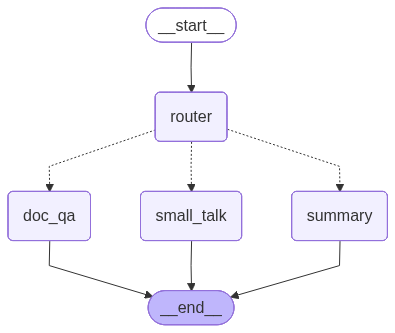


✅ 그래프 시각화 완료

[그래프 구조 설명]
  1. START: 그래프 시작점
  2. router: 사용자 질문을 분석하여 intent 설정
  3. 조건부 엣지: intent 값에 따라 분기
     - DOC_QA → doc_qa 노드
     - SUMMARY → summary 노드
     - SMALL_TALK → small_talk 노드
  4. 처리 노드: 각각 답변 생성
  5. END: 그래프 종료



In [24]:
print("\n" + "="*80)
print("Cell 26: 3.4 그래프 시각화 (선택)")
print("="*80)

try:
    # Mermaid 다이어그램 생성
    print("\n[1/2] Mermaid 다이어그램 생성 중...")
    
    from IPython.display import Image, display
    
    # 그래프를 이미지로 변환
    graph_image = app.get_graph().draw_mermaid_png()
    
    print("  ✅ 다이어그램 생성 완료")
    
    # 이미지 표시
    print("\n[2/2] 그래프 시각화:")
    display(Image(graph_image))
    
    print("\n✅ 그래프 시각화 완료")
    
except Exception as e:
    print(f"\n⚠️ 그래프 시각화 실패: {e}")
    print("\n대신 텍스트로 그래프 구조 출력:")
    print("""
    ┌─────────┐
    │  START  │
    └────┬────┘
         ↓
    ┌────────────┐
    │   router   │ (의도 분류)
    └────┬───────┘
         ↓ (조건부 엣지)
    ┌────┴────┬─────────┬──────────────┐
    │ doc_qa  │ summary │ small_talk   │
    └────┬────┴────┬────┴──────┬───────┘
         ↓         ↓           ↓
    ┌────────────────────────────────┐
    │            END                 │
    └────────────────────────────────┘
    """)

print("""
[그래프 구조 설명]
  1. START: 그래프 시작점
  2. router: 사용자 질문을 분석하여 intent 설정
  3. 조건부 엣지: intent 값에 따라 분기
     - DOC_QA → doc_qa 노드
     - SUMMARY → summary 노드
     - SMALL_TALK → small_talk 노드
  4. 처리 노드: 각각 답변 생성
  5. END: 그래프 종료
""")

In [25]:
print("\n" + "="*80)
print("Cell 27: 3.5 단일 턴 테스트")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 테스트 설정
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# thread_id 설정 (세션 구분)
config = {"configurable": {"thread_id": "test-session-1"}}

test_questions = [
    "RAG란 무엇인가요?",           # DOC_QA 예상
    "LangGraph 개념을 요약해줘",    # SUMMARY 예상
    "안녕하세요!",                 # SMALL_TALK 예상
]

print(f"총 {len(test_questions)}개 질문 테스트\n")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 각 질문 실행
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

for i, question in enumerate(test_questions, 1):
    print("="*80)
    print(f"테스트 {i}/{len(test_questions)}: '{question}'")
    print("="*80)
    
    # 초기 상태 구성
    initial_state = {
        "messages": [HumanMessage(content=question)],
        "query": question,
        "intent": "",
        "context": ""
    }
    
    # 그래프 실행
    print("\n[그래프 실행 중...]")
    result = app.invoke(initial_state, config=config)
    
    # 결과 출력
    print("\n" + "─"*80)
    print("[실행 결과]")
    print("─"*80)
    print(f"  분류된 의도: {result['intent']}")
    print(f"  답변: {result['messages'][-1].content[:200]}...")
    if result.get('context'):
        print(f"  Context 사용: ✅ ({len(result['context'])} chars)")
    else:
        print(f"  Context 사용: ❌")
    print()

print("="*80)
print("✅ 단일 턴 테스트 완료")
print("="*80)


Cell 27: 3.5 단일 턴 테스트
총 3개 질문 테스트

테스트 1/3: 'RAG란 무엇인가요?'

[그래프 실행 중...]

[Router] 질문 분석 중: 'RAG란 무엇인가요?'
  ✅ 분류된 의도: DOC_QA

[Route] 현재 의도: DOC_QA
  → 다음 노드: doc_qa

[DOC_QA] 질문: 'RAG란 무엇인가요?'
  [1/3] Retriever로 문서 검색 중...
  ✅ 4개 문서 검색 완료
  [2/3] LLM으로 답변 생성 중...
  ✅ 답변 생성 완료 (401 characters)
  [3/3] State 업데이트 중...
  ✅ DOC_QA 노드 완료

────────────────────────────────────────────────────────────────────────────────
[실행 결과]
────────────────────────────────────────────────────────────────────────────────
  분류된 의도: DOC_QA
  답변: RAG는 Retrieval-Augmented Generation의 약자로, 대형 언어 모델(LLM)이 질문에 대한 답변을 생성할 때 외부 지식을 검색하여 통합하는 방법입니다. RAG는 두 가지 주요 단계를 포함합니다: 

1. **검색(Retrieve)**: 사용자 입력에 따라 관련 문서를 검색합니다.
2. **생성(Generate)**: 검색된 데이터를 ...
  Context 사용: ✅ (12653 chars)

테스트 2/3: 'LangGraph 개념을 요약해줘'

[그래프 실행 중...]

[Router] 질문 분석 중: 'LangGraph 개념을 요약해줘'
  ✅ 분류된 의도: SUMMARY

[Route] 현재 의도: SUMMARY
  → 다음 노드: summary

[SUMMARY] 요청: 'LangGraph 개념을 요약해줘'
  [1/3] Retriever로 문서 검색 중...
  ✅ 4개 문서 검색 완료
  [2

# Section 4: 멀티턴 대화 및 시나리오 테스트 (Milestone 5)
---

## 목표
- 3개 시나리오 설계 및 실행
- 멀티턴 대화 테스트
- 메모리 동작 확인
- 의도 분류 정확도 평가

## 테스트 시나리오 (과제 요구사항)

### 시나리오 1: DOC_QA 위주
- 기술 문서 질문 연속
- Follow-up 질문
- 비교 요청

### 시나리오 2: SUMMARY 위주
- 문서 요약 요청
- 추가 요약 요청
- 세부 질문

### 시나리오 3: Mixed (혼합)
- 인사 (SMALL_TALK)
- 기술 질문 (DOC_QA)
- 요약 요청 (SUMMARY)
- 감사 인사 (SMALL_TALK)

## 평가 항목
- 의도 분류 정확도
- 라우팅 성공 여부
- 답변 품질
- 메모리 유지 여부

In [26]:
print("="*80)
print("Cell 30: 4.1 시나리오 설계")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 3개 시나리오 정의
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

scenarios = {
    "시나리오 1: DOC_QA 위주": {
        "description": "기술 문서에 대한 연속 질문",
        "turns": [
            {"query": "RAG란 무엇인가요?", "expected_intent": "DOC_QA"},
            {"query": "그것은 어떻게 작동하나요?", "expected_intent": "DOC_QA"},
            {"query": "Retriever의 종류는 무엇이 있나요?", "expected_intent": "DOC_QA"},
            {"query": "LangGraph와 LangChain의 차이점은?", "expected_intent": "DOC_QA"},
        ]
    },
    
    "시나리오 2: SUMMARY 위주": {
        "description": "문서 요약 및 정리 요청",
        "turns": [
            {"query": "RAG 개념을 요약해주세요", "expected_intent": "SUMMARY"},
            {"query": "핵심 포인트 3개만 뽑아줘", "expected_intent": "SUMMARY"},
            {"query": "더 간단하게 정리해주세요", "expected_intent": "SUMMARY"},
            {"query": "첫 번째 포인트를 자세히 설명해줘", "expected_intent": "DOC_QA"},
        ]
    },
    
    "시나리오 3: Mixed (혼합)": {
        "description": "다양한 의도가 섞인 자연스러운 대화",
        "turns": [
            {"query": "안녕하세요!", "expected_intent": "SMALL_TALK"},
            {"query": "LangGraph에 대해 알려주세요", "expected_intent": "DOC_QA"},
            {"query": "방금 설명한 내용을 요약해줘", "expected_intent": "SUMMARY"},
            {"query": "State는 어떻게 사용하나요?", "expected_intent": "DOC_QA"},
            {"query": "도움 주셔서 감사합니다!", "expected_intent": "SMALL_TALK"},
        ]
    }
}

print(f"총 {len(scenarios)}개 시나리오 정의 완료\n")

for name, scenario in scenarios.items():
    print(f"\n{name}")
    print(f"  설명: {scenario['description']}")
    print(f"  턴 수: {len(scenario['turns'])}턴")
    print(f"  예상 의도:")
    for i, turn in enumerate(scenario['turns'], 1):
        print(f"    Turn {i}: {turn['expected_intent']}")

print("\n" + "="*80)
print("✅ 시나리오 설계 완료")
print("="*80)

Cell 30: 4.1 시나리오 설계
총 3개 시나리오 정의 완료


시나리오 1: DOC_QA 위주
  설명: 기술 문서에 대한 연속 질문
  턴 수: 4턴
  예상 의도:
    Turn 1: DOC_QA
    Turn 2: DOC_QA
    Turn 3: DOC_QA
    Turn 4: DOC_QA

시나리오 2: SUMMARY 위주
  설명: 문서 요약 및 정리 요청
  턴 수: 4턴
  예상 의도:
    Turn 1: SUMMARY
    Turn 2: SUMMARY
    Turn 3: SUMMARY
    Turn 4: DOC_QA

시나리오 3: Mixed (혼합)
  설명: 다양한 의도가 섞인 자연스러운 대화
  턴 수: 5턴
  예상 의도:
    Turn 1: SMALL_TALK
    Turn 2: DOC_QA
    Turn 3: SUMMARY
    Turn 4: DOC_QA
    Turn 5: SMALL_TALK

✅ 시나리오 설계 완료


In [27]:
print("\n" + "="*80)
print("Cell 31: 4.2 시나리오 실행 함수")
print("="*80)

def run_scenario(scenario_name: str, scenario_data: dict, thread_id: str):
    """시나리오 실행 함수
    
    Args:
        scenario_name: 시나리오 이름
        scenario_data: 시나리오 데이터 (turns 리스트)
        thread_id: 세션 ID
        
    Returns:
        실행 결과 리스트
    """
    print("\n" + "="*80)
    print(f"시나리오 실행: {scenario_name}")
    print("="*80)
    print(f"설명: {scenario_data['description']}")
    print(f"턴 수: {len(scenario_data['turns'])}턴")
    print(f"Thread ID: {thread_id}")
    print("="*80)
    
    config = {"configurable": {"thread_id": thread_id}}
    results = []
    
    for i, turn in enumerate(scenario_data['turns'], 1):
        query = turn['query']
        expected_intent = turn['expected_intent']
        
        print(f"\n{'─'*80}")
        print(f"Turn {i}/{len(scenario_data['turns'])}")
        print(f"{'─'*80}")
        print(f"질문: {query}")
        print(f"예상 의도: {expected_intent}")
        
        # 초기 상태 구성
        initial_state = {
            "messages": [HumanMessage(content=query)],
            "query": query,
            "intent": "",
            "context": ""
        }
        
        # 그래프 실행
        try:
            result = app.invoke(initial_state, config=config)
            
            actual_intent = result['intent']
            answer = result['messages'][-1].content
            
            # 의도 일치 여부
            intent_match = actual_intent == expected_intent
            
            print(f"\n[결과]")
            print(f"  실제 의도: {actual_intent}")
            print(f"  의도 일치: {'✅' if intent_match else '❌'}")
            print(f"  답변 길이: {len(answer)} characters")
            print(f"  답변 미리보기: {answer[:150]}...")
            
            # 결과 저장
            results.append({
                "turn": i,
                "query": query,
                "expected_intent": expected_intent,
                "actual_intent": actual_intent,
                "intent_match": intent_match,
                "answer": answer,
                "context_used": bool(result.get('context'))
            })
            
        except Exception as e:
            print(f"\n❌ 오류 발생: {e}")
            results.append({
                "turn": i,
                "query": query,
                "expected_intent": expected_intent,
                "actual_intent": "ERROR",
                "intent_match": False,
                "answer": "",
                "context_used": False
            })
    
    print("\n" + "="*80)
    print(f"✅ {scenario_name} 완료")
    print("="*80)
    
    return results

print("✅ 시나리오 실행 함수 정의 완료")


Cell 31: 4.2 시나리오 실행 함수
✅ 시나리오 실행 함수 정의 완료


In [28]:
print("\n" + "="*80)
print("Cell 32: 4.3 시나리오 1 실행 (DOC_QA 위주)")
print("="*80)

scenario_1_results = run_scenario(
    "시나리오 1: DOC_QA 위주",
    scenarios["시나리오 1: DOC_QA 위주"],
    thread_id="scenario-1-doc-qa"
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 결과 분석
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("시나리오 1 결과 분석")
print("="*80)

total_turns = len(scenario_1_results)
correct_intents = sum(1 for r in scenario_1_results if r['intent_match'])
accuracy = (correct_intents / total_turns * 100) if total_turns > 0 else 0

print(f"\n의도 분류 정확도: {correct_intents}/{total_turns} ({accuracy:.1f}%)")

print("\n턴별 결과:")
print("-" * 80)
print(f"{'Turn':<6} | {'예상':<12} | {'실제':<12} | {'일치':<6}")
print("-" * 80)
for r in scenario_1_results:
    match_symbol = "✅" if r['intent_match'] else "❌"
    print(f"{r['turn']:<6} | {r['expected_intent']:<12} | {r['actual_intent']:<12} | {match_symbol:<6}")
print("-" * 80)

print(f"\n특징:")
print(f"  - 모든 질문이 DOC_QA 예상")
print(f"  - Follow-up 질문 포함 (Turn 2: '그것은...')")
print(f"  - Context 사용: {sum(1 for r in scenario_1_results if r['context_used'])}/{total_turns}턴")


Cell 32: 4.3 시나리오 1 실행 (DOC_QA 위주)

시나리오 실행: 시나리오 1: DOC_QA 위주
설명: 기술 문서에 대한 연속 질문
턴 수: 4턴
Thread ID: scenario-1-doc-qa

────────────────────────────────────────────────────────────────────────────────
Turn 1/4
────────────────────────────────────────────────────────────────────────────────
질문: RAG란 무엇인가요?
예상 의도: DOC_QA

[Router] 질문 분석 중: 'RAG란 무엇인가요?'
  ✅ 분류된 의도: DOC_QA

[Route] 현재 의도: DOC_QA
  → 다음 노드: doc_qa

[DOC_QA] 질문: 'RAG란 무엇인가요?'
  [1/3] Retriever로 문서 검색 중...
  ✅ 4개 문서 검색 완료
  [2/3] LLM으로 답변 생성 중...
  ✅ 답변 생성 완료 (287 characters)
  [3/3] State 업데이트 중...
  ✅ DOC_QA 노드 완료

[결과]
  실제 의도: DOC_QA
  의도 일치: ✅
  답변 길이: 287 characters
  답변 미리보기: RAG는 Retrieval-Augmented Generation의 약자로, 대형 언어 모델(LLM)이 질문에 대한 답변을 생성할 때 외부 지식을 검색하여 통합하는 방법론입니다. RAG는 두 가지 주요 단계로 구성됩니다: 

1. **검색(Retrieve)**: 사용자 ...

────────────────────────────────────────────────────────────────────────────────
Turn 2/4
────────────────────────────────────────────────────────────────────────────────
질문: 그것은 어떻게 작동하나요?
예

In [29]:
print("\n" + "="*80)
print("Cell 33: 4.4 시나리오 2 실행 (SUMMARY 위주)")
print("="*80)

scenario_2_results = run_scenario(
    "시나리오 2: SUMMARY 위주",
    scenarios["시나리오 2: SUMMARY 위주"],
    thread_id="scenario-2-summary"
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 결과 분석
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("시나리오 2 결과 분석")
print("="*80)

total_turns = len(scenario_2_results)
correct_intents = sum(1 for r in scenario_2_results if r['intent_match'])
accuracy = (correct_intents / total_turns * 100) if total_turns > 0 else 0

print(f"\n의도 분류 정확도: {correct_intents}/{total_turns} ({accuracy:.1f}%)")

print("\n턴별 결과:")
print("-" * 80)
print(f"{'Turn':<6} | {'예상':<12} | {'실제':<12} | {'일치':<6}")
print("-" * 80)
for r in scenario_2_results:
    match_symbol = "✅" if r['intent_match'] else "❌"
    print(f"{r['turn']:<6} | {r['expected_intent']:<12} | {r['actual_intent']:<12} | {match_symbol:<6}")
print("-" * 80)

print(f"\n특징:")
print(f"  - Turn 1-3: SUMMARY (요약 요청)")
print(f"  - Turn 4: DOC_QA (세부 설명 요청)")
print(f"  - 의도 전환 테스트")


Cell 33: 4.4 시나리오 2 실행 (SUMMARY 위주)

시나리오 실행: 시나리오 2: SUMMARY 위주
설명: 문서 요약 및 정리 요청
턴 수: 4턴
Thread ID: scenario-2-summary

────────────────────────────────────────────────────────────────────────────────
Turn 1/4
────────────────────────────────────────────────────────────────────────────────
질문: RAG 개념을 요약해주세요
예상 의도: SUMMARY

[Router] 질문 분석 중: 'RAG 개념을 요약해주세요'
  ✅ 분류된 의도: SUMMARY

[Route] 현재 의도: SUMMARY
  → 다음 노드: summary

[SUMMARY] 요청: 'RAG 개념을 요약해주세요'
  [1/3] Retriever로 문서 검색 중...
  ✅ 4개 문서 검색 완료
  [2/3] LLM으로 요약 생성 중...
  ✅ 요약 생성 완료 (500 characters)
  [3/3] State 업데이트 중...
  ✅ SUMMARY 노드 완료

[결과]
  실제 의도: SUMMARY
  의도 일치: ✅
  답변 길이: 500 characters
  답변 미리보기: RAG(검색 증강 생성)의 개념 요약:

1. **정의**: RAG는 LLM이 외부 지식을 검색하여 답변을 생성하는 방식으로, LLM의 한계를 극복하기 위해 설계됨.
   
2. **구성 요소**:
   - **문서 로더**: 외부 데이터 소스에서 데이터를 가져옴.
 ...

────────────────────────────────────────────────────────────────────────────────
Turn 2/4
────────────────────────────────────────────────────────────────────────────────
질문:

In [30]:
print("\n" + "="*80)
print("Cell 34: 4.5 시나리오 3 실행 (Mixed)")
print("="*80)

scenario_3_results = run_scenario(
    "시나리오 3: Mixed (혼합)",
    scenarios["시나리오 3: Mixed (혼합)"],
    thread_id="scenario-3-mixed"
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 결과 분석
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("시나리오 3 결과 분석")
print("="*80)

total_turns = len(scenario_3_results)
correct_intents = sum(1 for r in scenario_3_results if r['intent_match'])
accuracy = (correct_intents / total_turns * 100) if total_turns > 0 else 0

print(f"\n의도 분류 정확도: {correct_intents}/{total_turns} ({accuracy:.1f}%)")

print("\n턴별 결과:")
print("-" * 80)
print(f"{'Turn':<6} | {'예상':<12} | {'실제':<12} | {'일치':<6}")
print("-" * 80)
for r in scenario_3_results:
    match_symbol = "✅" if r['intent_match'] else "❌"
    print(f"{r['turn']:<6} | {r['expected_intent']:<12} | {r['actual_intent']:<12} | {match_symbol:<6}")
print("-" * 80)

print(f"\n특징:")
print(f"  - 3가지 의도 모두 포함")
print(f"  - SMALL_TALK → DOC_QA → SUMMARY → DOC_QA → SMALL_TALK")
print(f"  - 가장 자연스러운 대화 시나리오")


Cell 34: 4.5 시나리오 3 실행 (Mixed)

시나리오 실행: 시나리오 3: Mixed (혼합)
설명: 다양한 의도가 섞인 자연스러운 대화
턴 수: 5턴
Thread ID: scenario-3-mixed

────────────────────────────────────────────────────────────────────────────────
Turn 1/5
────────────────────────────────────────────────────────────────────────────────
질문: 안녕하세요!
예상 의도: SMALL_TALK

[Router] 질문 분석 중: '안녕하세요!'
  ✅ 분류된 의도: SMALL_TALK

[Route] 현재 의도: SMALL_TALK
  → 다음 노드: small_talk

[SMALL_TALK] 대화: '안녕하세요!'
  [1/2] LLM으로 답변 생성 중...
  ✅ 답변 생성 완료 (18 characters)
  [2/2] State 업데이트 중...
  ✅ SMALL_TALK 노드 완료

[결과]
  실제 의도: SMALL_TALK
  의도 일치: ✅
  답변 길이: 18 characters
  답변 미리보기: 안녕하세요! 어떻게 도와드릴까요?...

────────────────────────────────────────────────────────────────────────────────
Turn 2/5
────────────────────────────────────────────────────────────────────────────────
질문: LangGraph에 대해 알려주세요
예상 의도: DOC_QA

[Router] 질문 분석 중: 'LangGraph에 대해 알려주세요'
  ✅ 분류된 의도: DOC_QA

[Route] 현재 의도: DOC_QA
  → 다음 노드: doc_qa

[DOC_QA] 질문: 'LangGraph에 대해 알려주세요'
  [1/3] Retr

In [31]:
print("\n" + "="*80)
print("Cell 35: 4.6 종합 평가")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 전체 결과 집계
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

all_results = {
    "시나리오 1": scenario_1_results,
    "시나리오 2": scenario_2_results,
    "시나리오 3": scenario_3_results
}

total_all_turns = sum(len(results) for results in all_results.values())
total_correct = sum(
    sum(1 for r in results if r['intent_match'])
    for results in all_results.values()
)
overall_accuracy = (total_correct / total_all_turns * 100) if total_all_turns > 0 else 0

print("\n" + "="*80)
print("전체 시나리오 종합 평가")
print("="*80)

print(f"\n총 통계:")
print(f"  - 총 시나리오: {len(all_results)}개")
print(f"  - 총 턴 수: {total_all_turns}턴")
print(f"  - 의도 분류 정확도: {total_correct}/{total_all_turns} ({overall_accuracy:.1f}%)")

# 시나리오별 정확도
print(f"\n시나리오별 정확도:")
print("-" * 80)
print(f"{'시나리오':<20} | {'턴 수':<8} | {'정확도':<15}")
print("-" * 80)
for name, results in all_results.items():
    total = len(results)
    correct = sum(1 for r in results if r['intent_match'])
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"{name:<20} | {total:<8} | {correct}/{total} ({accuracy:.1f}%)")
print("-" * 80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 의도별 통계
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

from collections import Counter

intent_stats = Counter()
for results in all_results.values():
    for r in results:
        intent_stats[r['actual_intent']] += 1

print(f"\n의도별 통계:")
print("-" * 80)
print(f"{'의도':<15} | {'횟수':<10}")
print("-" * 80)
for intent, count in intent_stats.most_common():
    print(f"{intent:<15} | {count:<10}")
print("-" * 80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Context 사용 통계
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

total_context_used = sum(
    sum(1 for r in results if r['context_used'])
    for results in all_results.values()
)

print(f"\nRAG 사용 통계:")
print(f"  - Context 사용: {total_context_used}/{total_all_turns}턴")
print(f"  - 예상: DOC_QA + SUMMARY에서만 사용")


Cell 35: 4.6 종합 평가

전체 시나리오 종합 평가

총 통계:
  - 총 시나리오: 3개
  - 총 턴 수: 13턴
  - 의도 분류 정확도: 13/13 (100.0%)

시나리오별 정확도:
--------------------------------------------------------------------------------
시나리오                 | 턴 수      | 정확도            
--------------------------------------------------------------------------------
시나리오 1               | 4        | 4/4 (100.0%)
시나리오 2               | 4        | 4/4 (100.0%)
시나리오 3               | 5        | 5/5 (100.0%)
--------------------------------------------------------------------------------

의도별 통계:
--------------------------------------------------------------------------------
의도              | 횟수        
--------------------------------------------------------------------------------
DOC_QA          | 7         
SUMMARY         | 4         
SMALL_TALK      | 2         
--------------------------------------------------------------------------------

RAG 사용 통계:
  - Context 사용: 11/13턴
  - 예상: DOC_QA + SUMMARY에서만 사용


In [33]:
print("\n" + "="*80)
print("Cell 36: 4.7 메모리 동작 확인")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 각 시나리오의 메모리 상태 확인
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

thread_ids = [
    ("scenario-1-doc-qa", "시나리오 1"),
    ("scenario-2-summary", "시나리오 2"),
    ("scenario-3-mixed", "시나리오 3")
]

print("\n각 시나리오의 메모리 상태:\n")

for thread_id, scenario_name in thread_ids:
    config = {"configurable": {"thread_id": thread_id}}
    
    try:
        # State 가져오기
        state = app.get_state(config)
        
        # 메시지 수 계산
        message_count = len(state.values.get('messages', []))
        turns = message_count // 2  # Human + AI 페어
        
        print(f"{scenario_name} (thread_id: {thread_id})")
        print(f"  - 저장된 메시지: {message_count}개")
        print(f"  - 대화 턴 수: {turns}턴")
        print(f"  - 마지막 의도: {state.values.get('intent', 'N/A')}")
        print()
        
    except Exception as e:
        print(f"{scenario_name}: ⚠️ State 가져오기 실패 - {e}")
        print()


Cell 36: 4.7 메모리 동작 확인

각 시나리오의 메모리 상태:

시나리오 1 (thread_id: scenario-1-doc-qa)
  - 저장된 메시지: 8개
  - 대화 턴 수: 4턴
  - 마지막 의도: DOC_QA

시나리오 2 (thread_id: scenario-2-summary)
  - 저장된 메시지: 8개
  - 대화 턴 수: 4턴
  - 마지막 의도: DOC_QA

시나리오 3 (thread_id: scenario-3-mixed)
  - 저장된 메시지: 10개
  - 대화 턴 수: 5턴
  - 마지막 의도: SMALL_TALK



In [34]:
def chat_interface():
    """대화형 인터페이스"""
    import uuid
    
    print("\n" + "="*80)
    print("LangGraph 인지 아키텍처 챗봇")
    print("="*80)
    print("명령어:")
    print("  - 'exit' / '종료': 종료")
    print("  - 'reset': 대화 초기화")
    print("="*80)
    
    # 초기 thread_id
    thread_id = f"chat-{uuid.uuid4().hex[:8]}"
    config = {"configurable": {"thread_id": thread_id}}
    
    turn_count = 0
    
    while True:
        # 사용자 입력
        user_input = input(f"\n[Turn {turn_count + 1}] 질문: ").strip()
        
        if not user_input:
            continue
        
        # 종료
        if user_input.lower() in ["exit", "quit", "종료"]:
            print(f"\n총 {turn_count}턴 대화 완료. 종료합니다.")
            break
        
        # 초기화
        if user_input.lower() == "reset":
            thread_id = f"chat-{uuid.uuid4().hex[:8]}"
            config = {"configurable": {"thread_id": thread_id}}
            turn_count = 0
            print(f"✅ 대화 초기화 완료 (새 thread_id: {thread_id})")
            continue
        
        # 그래프 실행
        try:
            initial_state = {
                "messages": [HumanMessage(content=user_input)],
                "query": user_input,
                "intent": "",
                "context": ""
            }
            
            result = app.invoke(initial_state, config=config)
            
            # 결과 출력
            intent = result['intent']
            answer = result['messages'][-1].content
            
            print(f"\n[의도: {intent}]")
            print(f"{answer}")
            
            turn_count += 1
            
        except Exception as e:
            print(f"\n❌ 오류: {e}")

# chat_interface()